In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as nn_functional
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


In [16]:
# Lets define the model architecture
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=392, latent_dim=3):

        super(VariationalAutoencoder, self).__init__()               # initialize the VariationalAutoencoder class

        # lets define the encoder architecture as a sequential container
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),     # first Linear layer: input_dim -> hidden_dim.
            nn.LeakyReLU(0.3),                    # apply LeakyReLU with a negative solve of 0.3
            nn.Linear(hidden_dim, hidden_dim),    # second Linear layer: hidden_dim -> hidden_dim
            nn.LeakyReLU(0.3)                     # apply LeakyReLU activation
        )

        # lets define the Latent space layers
        self.mean_layer         = nn.Linear(hidden_dim, latent_dim)     # Linear layer to predict the mean (μ) of the latent gaussian distribution
        self.log_variance_layer = nn.Linear(hidden_dim, latent_dim)     # Linear layer to predict the log variance (log(σ²)) of the latent Gaussian distribution

        # lets define the decoder architecture as a sequential container
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),    # a Linear layer: latent_dim -> hidden_dim
            nn.LeakyReLU(0.3),                    # apply LeakyReLU activation function with a negative solve of 0.3
            nn.Linear(hidden_dim, hidden_dim),    # another Linear layer: hidden_dim -> hidden_dim
            nn.LeakyReLU(0.3),                    # apply LeakyReLU activation function with a negative solve of 0.3
            nn.Linear(hidden_dim, input_dim),     # Final Linear layer: hidden_dim -> input_dim to reconstruct the input
            nn.Sigmoid()                          # Sigmoid activation function so that output values are squashed between 0 and 1
        )

    def encode(self, x):

        # view takes *shape as the parameter so we can pass a shape to it to get a flattened view of the input
        # so x.view(x.size(0), -1) means preserve the first dimension - x.size(0)
        # i.e the batch size but flatten all other dimensions so (batch_size, 1, 28, 28) becomes (batch_size, 1*28*28)  = (batch_size, 784)

        # reshape the input tensor x to flatten all dimensions except the batch size so its shape becomes:  (batch_size, 784)
        x = x.view(x.size(0), -1)

        # pass the flattened input 'x' through the encoder layers to obtain a hidden representation which contains features extracted by the encoder, its shape is (batch_size, hidden_dim)
        hidden_representation = self.encoder(x)

        # pass the hidden representation through the mean layer to get the latent space mean (μ), its shape is (batch_size, latent_dim)
        latent_mean = self.mean_layer(hidden_representation)

        # pass the hidden reprensetation throught the log variance layer to get the latent space log variance (log(σ²)), its shape (batch_size, latent_dim)
        latent_log_variance = self.log_variance_layer(hidden_representation)

        return latent_mean, latent_log_variance, hidden_representation


    @staticmethod
    def reparameterize(mean, log_variance):
        # convert log_variance to standard_deviation by taking its a square root
        # torch.exp(0.5 * log_variance) is equivalent to sqrt(log_variance). Thus, its shape is also (batch_size, latent_dim)
        standard_deviation = torch.exp(0.5 * log_variance)

        # now, we generate a random noise 'episilon' from a standard normal distribution - N(0, 1) - which means it is a distribution with mean of 0, and standard deviation of 1
        # torch.randn_like(standard_deviation) creates a tensor of the same shape as standard_deviation (which we derived from log_variance by taking its square root)
        # which we know represents the log variance of the latent space. Therefore, we are randomly sampling from the learned distribution.

        epsilon = torch.randn_like(standard_deviation)                    # its shape is also (batch_size, latent_dim)

        # now we need to sample from the learned distrubution
        # reparameterization technique: z = μ + ε * σ, where ε ~ N(0,1), allows us to sample from a learned distribution and allows gradient flow which makes backpropagation possible

        sampled_latent_vector_z = mean + epsilon * standard_deviation    # its shape is also (batch_size, latent_dim)

        return sampled_latent_vector_z


    def decode(self, latent_vector_z):

        reconstructed_x = self.decoder(latent_vector_z) # pass the sampled_latent_vector_z through the decoder layers to reconstruct the input

        return reconstructed_x


    def forward(self, x):
        # pass the input through the encoder layers
        latent_mean, latent_log_variance, hidden_representation = self.encode(x)

        # Sample latent vector from the latent distribution by using reparameterization function above
        sampled_latent_vector_z = self.reparameterize(latent_mean, latent_log_variance)

        # pass the sampled_latent_vector z through the decoder layers to reconstruct the input
        reconstructed_x = self.decode(sampled_latent_vector_z)

        return reconstructed_x, latent_mean, latent_log_variance



In [17]:
# let's set up the loss and training functions
def loss_function(reconstructed_x, x, latent_mean, latent_log_variance):

    # Reconstruction loss (binary cross-entropy)
    binary_cross_entropy = nn_functional.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + latent_log_variance - latent_mean.pow(2) - latent_log_variance.exp())

    return binary_cross_entropy + kl_divergence


def train(model, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0

    for inputs, _ in train_loader:
        optimizer.zero_grad()

        # Forward pass
        reconstructed_inputs, latent_mean, latent_log_variance = model(inputs)

        # Compute loss
        batch_loss = loss_function(reconstructed_inputs, inputs, latent_mean, latent_log_variance)

        # Backward pass
        batch_loss.backward()

        epoch_loss += batch_loss.item()

        optimizer.step()

    print(f'Epoch: {epoch}, Average Loss: {epoch_loss / len(train_loader.dataset):.4f}')


# functions to save and load the model
def save_model(model, path='variational_autoencoder.pt'):
    torch.save(model.state_dict(), path)
    print(f"Model state dictionary saved to {path}")



def load_model(model, path='variational_autoencoder.pt'):
    model.load_state_dict(torch.load(path))
    model.eval()                            # Set to evaluation mode
    print(f"Model loaded from {path}")
    return model



def save_model_to_torch_script_format(model, path='variational_autoencoder_torch_script_format.pt'):
    model_scripted = torch.jit.script(model) # Export to TorchScript Format
    model_scripted.save(path)                # Save


def load_model_from_torch_script_format(path='variational_autoencoder_torch_script_format.pt'):
    return torch.jit.load(path)



In [18]:
# lets get our data loaded and ready
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_batch_size = 128

# MNIST dataset transformations
_transform = transforms.Compose([ transforms.ToTensor() ])

# Load MNIST training dataset
_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=_transform)
_train_loader = torch.utils.data.DataLoader(_train_dataset, batch_size=_batch_size, shuffle=True)

# Load MNIST test dataset
_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=_transform)
_test_loader = torch.utils.data.DataLoader(_test_dataset, batch_size=_batch_size, shuffle=False)



Dataset size: 60000
Image shape (C, H, W): torch.Size([1, 28, 28])
Label: 5
Batch image shape: torch.Size([128, 1, 28, 28])
Batch labels shape: torch.Size([128])


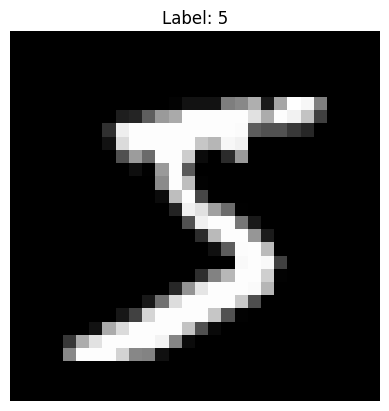

In [20]:
# lets check a few things about our data
# Check dataset size
print("Dataset size:", len(_train_dataset))

# Check the shape of one image and label
sample_image, sample_label = _train_dataset[0]
print("Image shape (C, H, W):", sample_image.shape)  # Should print torch.Size([1, 28, 28])
print("Label:", sample_label)

# Check batch shape
for images, labels in _train_loader:
    print("Batch image shape:", images.shape)   # [batch_size, 1, 28, 28]
    print("Batch labels shape:", labels.shape)  # [batch_size]
    break

# Display the first image to make sure things are okay
plt.imshow(sample_image[0], cmap='gray')  # [0] to remove the channel dimension for grayscale image
plt.title(f'Label: {sample_label}')
plt.axis('off')
plt.show()

In [21]:
# lets intialize the model and setup some hyperparameters for training
_model = VariationalAutoencoder()
_learning_rate = 1e-3

_optimizer = optim.Adam(_model.parameters(), lr=_learning_rate)

_epochs = 10

# # Training loop
for _epoch in range(1, _epochs + 1):
    train(_model, _train_loader, _optimizer, _epoch)

Epoch: 1, Average Loss: 171.0020
Epoch: 2, Average Loss: 150.5858
Epoch: 3, Average Loss: 147.0871
Epoch: 4, Average Loss: 144.8227
Epoch: 5, Average Loss: 143.0295
Epoch: 6, Average Loss: 141.6617
Epoch: 7, Average Loss: 140.4413
Epoch: 8, Average Loss: 139.4095
Epoch: 9, Average Loss: 138.6503
Epoch: 10, Average Loss: 137.8469


In [23]:
# lets save the model
save_model(_model)

# also in torchscript format
save_model_to_torch_script_format(_model)


Model state dictionary saved to variational_autoencoder.pt


In [24]:
# let us create an interactive 3d visualiztion of our latent space
def visualize_latent_space(_model, _train_loader):
    _model.eval()  # Set the model to evaluation mode
    all_latent_vectors = []
    all_labels = []

    with torch.no_grad():
        for data, labels in _train_loader:  # Iterate through the DataLoader
            data = data.to(next(_model.parameters()).device)  # Move data to the same device as the model
            latent_mean, _, _ = _model.encode(data)  # Get the latent mean (μ) from the encoder
            all_latent_vectors.append(latent_mean.cpu())  # Move to CPU and store
            all_labels.append(labels.cpu())  # Store labels

    # Stack all latent vectors and labels into NumPy arrays
    latent_vectors = torch.cat(all_latent_vectors).numpy()
    labels = torch.cat(all_labels).numpy()

    # Create an interactive 3D scatter plot using Plotly
    fig = go.Figure()

    # Add a scatter plot for each unique label
    unique_labels = set(labels)
    for label in unique_labels:
        indices = labels == label
        fig.add_trace(go.Scatter3d(
            x=latent_vectors[indices, 0],
            y=latent_vectors[indices, 1],
            z=latent_vectors[indices, 2],
            mode='markers',
            marker=dict(size=5, opacity=0.7),
            name=f"Class|Digit {label}"
        ))

    # Customize layout
    fig.update_layout(
        title="Interactive 3D Latent Space Visualization",
        scene=dict(
            xaxis_title="Latent Dimension 1",
            yaxis_title="Latent Dimension 2",
            zaxis_title="Latent Dimension 3"
        ),
        height=800

    )

    # Save the figure to HTML
    fig.write_html("latent3d.html", full_html=True)
    fig.show()

# call the function above
visualize_latent_space(_model, _train_loader)



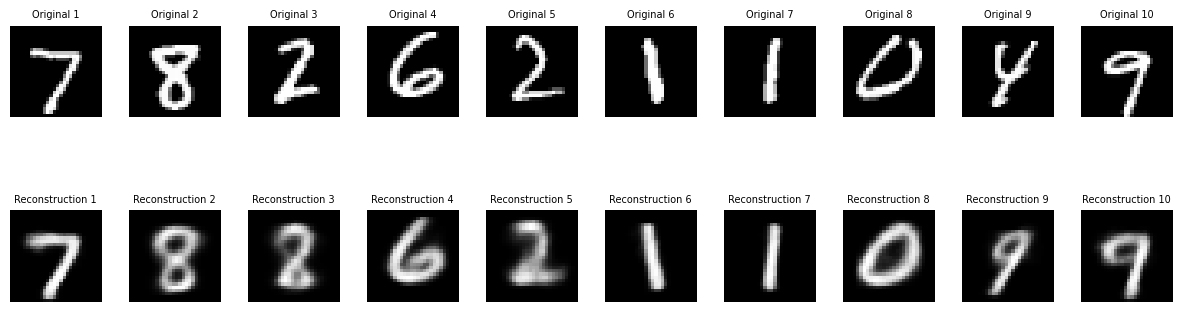

In [25]:
# lets try to generate some images using the test data set
def reconstruct_images_from_test_dataset(model, test_loader, device):
    model.eval().to(device)
    original_images, reconstructed_images = [], []

    with torch.no_grad():
        for images, _ in test_loader:
            if len(original_images) >= 10: break  # Stop after 10 original and reconstructed image pairs

            images = images.to(device)
            reconstructed, _, _ = model(images)

            original_images.append(images[0].cpu())
            reconstructed_images.append(reconstructed[0].cpu())

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        # Plot original images (top row)
        axes[0, i].imshow(original_images[i].view(28, 28).detach().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}', fontsize=7)

        # Plot reconstructed images (bottom row)
        axes[1, i].imshow(reconstructed_images[i].view(28, 28).detach().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstruction {i+1}', fontsize=7)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increase space between images
    plt.show()

# call the function above
reconstruct_images_from_test_dataset(_model, _test_loader, _device)



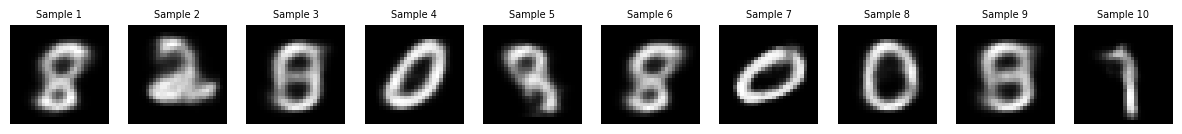

In [26]:
# now let us create a function that will sample from our latent space and generate new images based on random latent vectors
def generate_image_from_latent_space(model, device, n_samples=10):
    model.eval().to(device)  # Set the model to evaluation mode and move to device

    # Generate random latent vectors with shape (n_samples, latent_dim)
    latent_vectors = torch.randn(n_samples, 3).to(device)  # Latent space with 3 dimensions

    # Pass the latent vectors through the decoder to generate images
    with torch.no_grad():
        generated_images = model.decode(latent_vectors)

    # Plot the generated images
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 4))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Sample {i+1}', fontsize=7)

    plt.show()

# call the function above
generate_image_from_latent_space(_model, _device, 10)

